In [1]:
import src # make sure jupyter notebook is running in the environemnt with this project installed (pip install -r requirements.txt).
import pandas as pd
from pathlib import Path
from scipy import stats

project_dir = Path(src.__file__).parents[1]
data_dir = project_dir / 'data'

# Util function

In [75]:
def humanize(snake_case_string):
    return snake_case_string.replace('_', ' ')

# Analiza kadry medycznej
Na podstawie danych pobranych z BDL (bank danych ludności) prowadzonego przez główny urząd statystyczny chcemy przeanalizować jak zmieniała się kadra medyczna przez okres od 2010 roku do 2022.

In [91]:
def read_stats_folder(dir):
    data = [pd.read_csv(fname, index_col=0) for fname in dir.iterdir()]
    data = pd.concat(data, axis=1)
    return data 


def plot_bdl_stats(dir):
    data = read_stats_folder(dir)
    data.plot.bar(figsize=(10,10), 
                grid=True,
                title=f'{humanize(dir.name).capitalize()} variables')
    

In [82]:
folders_with_stats = list((data_dir / 'raw' / 'medical_staff_stats_bdl').iterdir())
# Display stats that were collected from BDL
for i, var_name in enumerate(f.stem for f in folders_with_stats):
    print(f'Folder with {humanize(var_name)} stats has idx {i}')

Folder with medical staff stats has idx 0
Folder with midwives stats has idx 1
Folder with nurses stats has idx 2
Folder with rescuers stats has idx 3


# Analiza danych dla lekarzy pracujących w szpitalach


## Analiza liczebności

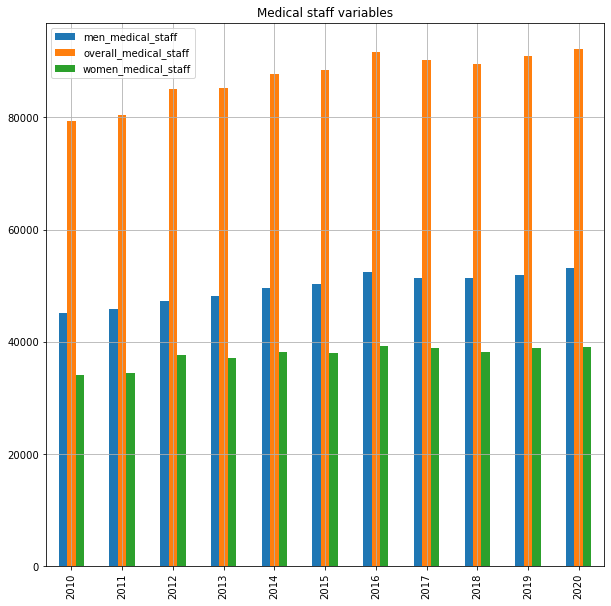

In [90]:
STATS_FOLDER_IDX = 0
plot_bdl_stats(folders_with_stats[STATS_FOLDER_IDX])


Na powyższym wykresie widzimy wzrost liczby lekarzy w latach od 2010 do 2018. W 2016 tendencja się odwraca i liczba spada aż do 2018, po czym znowu się odwraca. Ostatni pomiar zrobiony w 2020 pokazuje, że liczba lekarzy jest prawie równa tej która była przed 2016 rokiem.
Inną zauważalną cechą jest to, że większość lekarzy są mężczyznami. W dalszej części zostanie przeprowadzona trochę bardziej rzetelna analiza uzależniona od płci.

In [103]:
data = read_stats_folder(folders_with_stats[STATS_FOLDER_IDX])
MEN_COLUMN = 'men_medical_staff'
WOMEN_COLUMN = 'women_medical_staff'
OVERALL_COLUMN = 'overall_medical_staff'

## Analiza z podziałem na płeć

In [122]:
from collections import defaultdict
percentages = defaultdict(list)
for year, row in  data.iterrows():
    men_percentage = ((row[MEN_COLUMN] / row[OVERALL_COLUMN]) * 100).round().astype('int')
    women_percentage = ((row[WOMEN_COLUMN] / row[OVERALL_COLUMN]) * 100).round().astype('int')
    percentages[MEN_COLUMN].append(men_percentage)
    percentages[WOMEN_COLUMN].append(women_percentage)
    print(f'[{year}] - men: {men_percentage} %, women: {women_percentage} %, abs(men % - women %): {abs(men_percentage - women_percentage)} %')

print(f'Women mode: {stats.mode(percentages[MEN_COLUMN]).mode[0]} %')
print(f'Men mode: {stats.mode(percentages[WOMEN_COLUMN]).mode[0]} %')

[2010] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2011] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2012] - men: 56 %, women: 44 %, abs(men % - women %): 12 %
[2013] - men: 56 %, women: 44 %, abs(men % - women %): 12 %
[2014] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2015] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2016] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2017] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2018] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2019] - men: 57 %, women: 43 %, abs(men % - women %): 14 %
[2020] - men: 58 %, women: 42 %, abs(men % - women %): 16 %
Women mode: 57 %
Men mode: 43 %


Wnioski wynikające z powyższego podsumowania:
- procentowy udział mężczyzn jest zawsze conajmniej o 11 % większy od udziału kobiet
- przez okres 10 badanych lat nie było dużych zmian w procentowym udziale żadnej z płci. Pomiary oscylowały wokół wartości 57% dla mężczyzn oraz 43% dla kobiet.
- oscylacje nie są skorelowane z zmianami trendów wśród liczby lekarzy. W celach przypomnienienia powiem, że zmiany trendów liczebności były spostrzegane w 2016 oraz 2018 latach. Natomiast oscylacje w procentowym udziale widzimy w 2012, 2013 oraz 2020.

## Dalsze pytania

Po wykonaniu powyższej analizy pojawiają się następujące sensowne pytania:

- dlaczego procentowy udział kobiet jest mniejszy od procentowego udziały mężczyzn?
- dlaczego wiedzieliśmy odwrócenie trendu wzrostu wśród lekarzy w 2016 oraz 2018 latach?

W dalszych sekcjach będzie podjęta próba odpowiedzi na te pytania.

# Dlaczego procentowy udział kobiet jest mniejszy od procentowego udziały mężczyzn?


## Demograficzny skład Polski 

Możliwe, że powód takiego podziału jest naturalny i wynika z demograficznego składu Polski. 

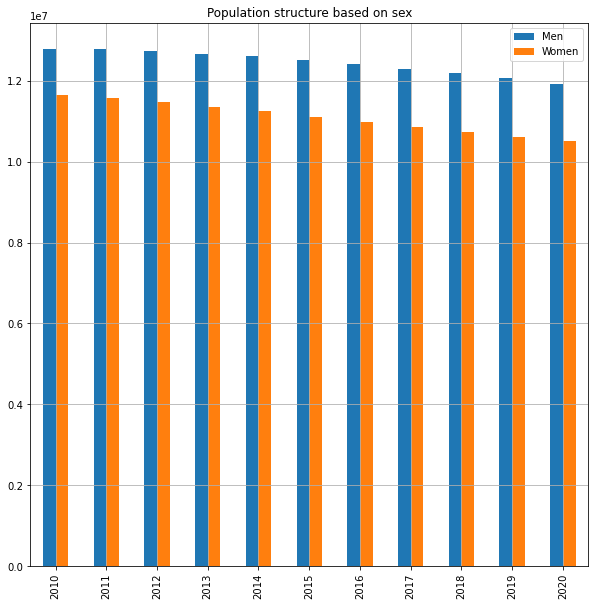

In [141]:
population_structure_over_years = pd.read_csv(data_dir / 'external' / 'ludnosc_wg_plci_w_wieku_produkcyjnym.csv', index_col=0)

_ = population_structure_over_years.plot.bar(
    figsize=(10, 10),
    title='Population in working age structure based on sex',
    grid=True,
)

Powyższy wykres uwzględnia tylko ludzi w wieku produkcyjnym (czyli mężczyzn od 18 do 64 lat oraz kobiet od 18 do 59).
Z wykresu jasno widać, że mężczyzn w spółeczeństwie jest więcej co tłumaczy dlaczego zawód lekarza jest bardziej popularny wśród mężczyzn niż wśród kobiet. 

Nie mniej jednak, ten wykres robi tylko ciekawszym pytanie o tym dlaczego widzieliśmy zmiany trendu w 2016 oraz 2018 latach, oraz pytanie dlaczego widzimy w danych rosnący trend, ponieważ widzimy, że liczba osób w wieku produkcyjnym maleje przez cały badany okres.

## Liczba maturzystów w latach 2000 - 2020


In [9]:
import pandas as pd
mat_df = pd.read_csv(r'..\data\external\liczba_osob_ktore_przystapily_lub_zdaly_egzamin_maturalny.csv', sep=';')

# mat_df.head()
ogolem_df = mat_df.loc[ (mat_df['wojewodztwo']=='Ogółem') & (mat_df['status_zdajacych'] == 'zdało')]


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


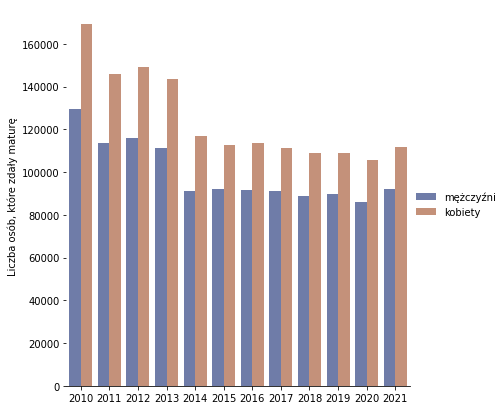

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.catplot(
    data=ogolem_df, kind="bar",
    x="rok", y="wartosc", hue="plec",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Liczba osób, które zdały maturę")
g.legend.set_title("")

<AxesSubplot:>

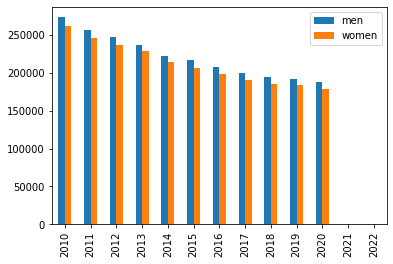

In [33]:
years = [str(n) for n in range(1995, 2023)]
men_19_df = pd.read_csv(r'..\data\external\men_19.csv', sep=';')
men_19_df.columns = ['Kod', 'Nazwa']+  years
women_19_df = pd.read_csv(r'..\data\external\women_19.csv', sep=';')
women_19_df.columns = ['Kod', 'Nazwa']+  years
#men_19_df.head()
merged_19 = men_19_df.append(women_19_df, ignore_index=True)
#women_19_df.head()
merged_19.head()

plot_data = pd.DataFrame({"years": years[15:], "men": merged_19.iloc[0][17:], "women": merged_19.iloc[1][17:]})

plot_data.plot(kind='bar')

Jak widać liczba osób które zdały maturę spada od 2010 roku w obydwu grupach wiekowych. Inną ciekawą rzeczą jaką można zauważyć, jest większa ilość kobiet niż mężczyzn wśród zdających maturę. Oczywistą przyczyną takiego stanu rzeczy może być większa ilość kobiet w danym przedziale wiekowym, ten czynnik należy jeszcze sprawdzić.

Przyjrzano się ilości osób w wieku 19 lat w latach 2010-2020. Co ciekawe, większość 19-latków stanowią mężczyźni. Należy wobec tego sprawdzić czy może większy udział kobiet wśród zdających maturę nie wynika z 

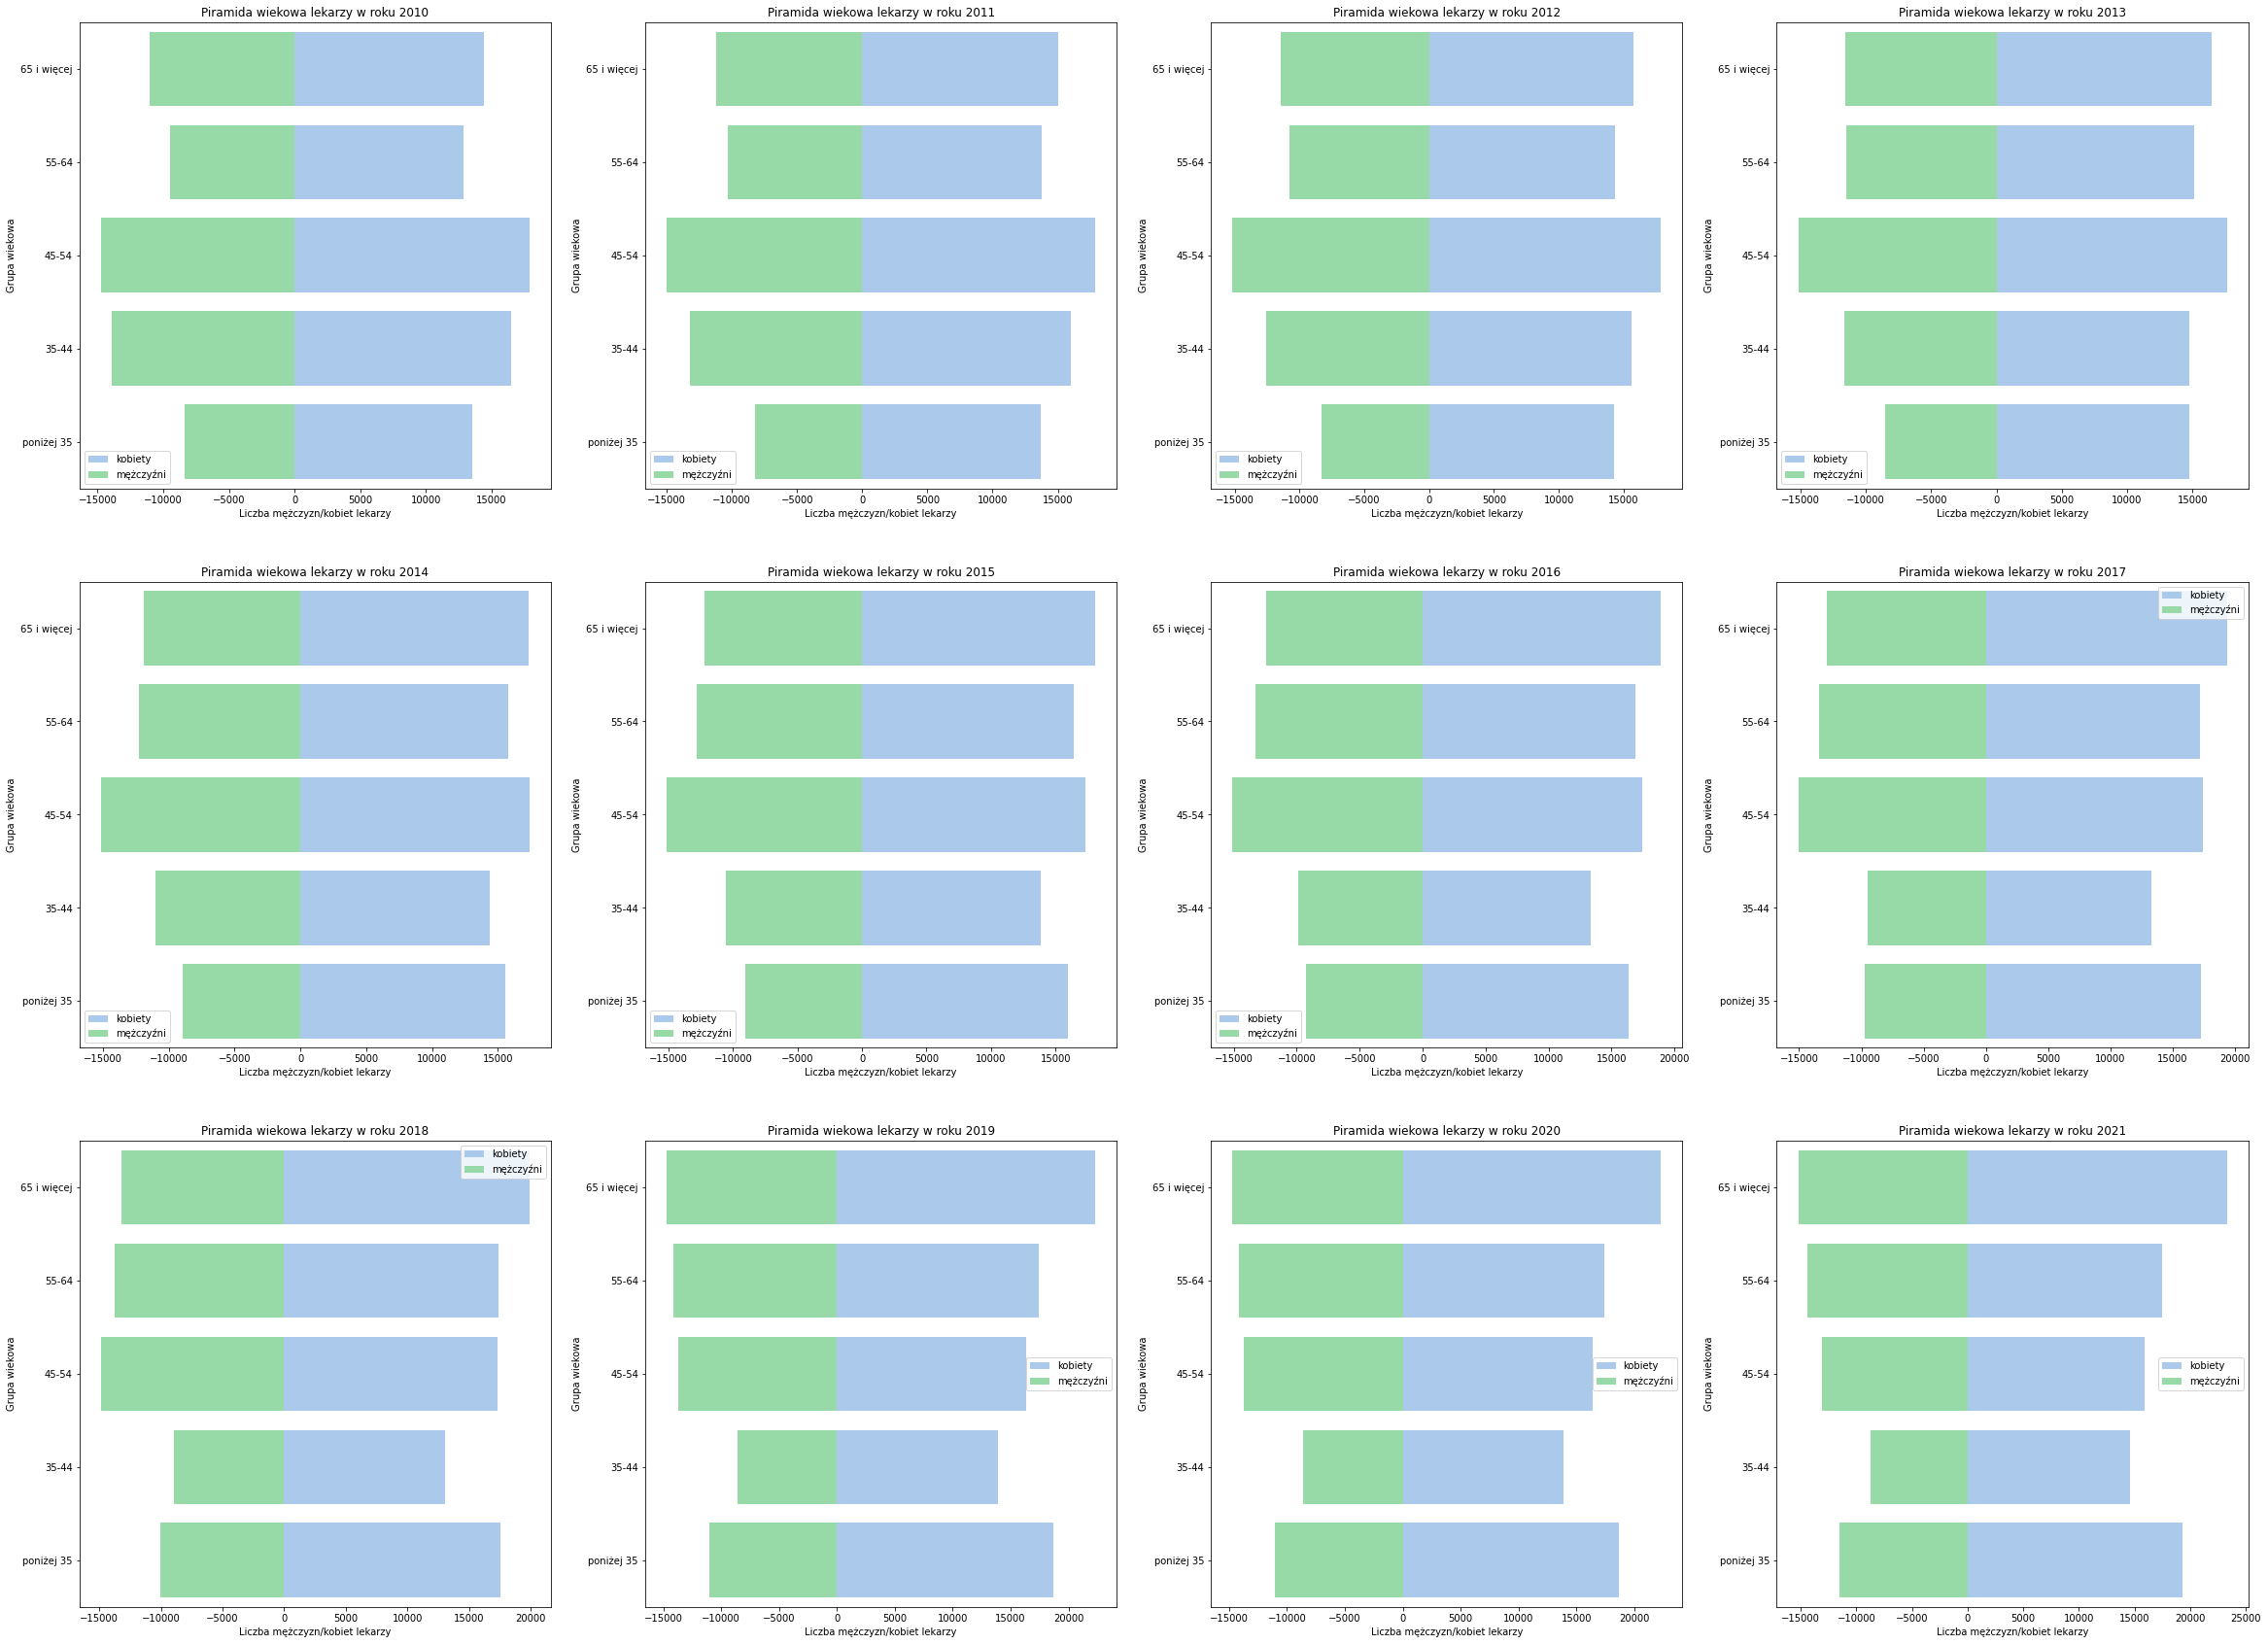

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

doc_age = pd.read_csv(r'..\data\external\doctors_age.csv')
doc_age.columns = [n.strip() for n in doc_age.columns]
plt.rcParams["figure.figsize"] = (40,30)
fig, axes = plt.subplots(3, 4)
sns.set_color_codes("pastel")
def barplot_pyramid(x1,y1,x2,y2,i,j):
    bar_plot = sns.barplot(ax=axes[i][j],x=x1, y=y1,data=df, order=ageclass[::-1], lw=0, color ="b", label="kobiety")
    bar_plot = sns.barplot(ax=axes[i][j],x=x2, y=y2, data=df, order=ageclass[::-1], lw=0, color="g", label="mężczyźni")
    bar_plot.set(xlabel="Liczba mężczyzn/kobiet lekarzy", ylabel="Grupa wiekowa", title = f"Piramida wiekowa lekarzy w roku {year}")
    bar_plot.legend()

for i,year in enumerate(range(2010,2022)):
    y = doc_age.loc[doc_age['rok'] == year]
    ageclass = ['poniżej 35', '35-44', '45-54', '55-64', '65 i więcej']
    women = [int(x.replace(" ", "")) for x in ((y.iloc[:,4:14:2]).values)[0]]
    men = [-(int(x.replace(" ",""))) for x in ((y.iloc[:,5:14:2]).values)[0]]
    df = pd.DataFrame({
        'Wiek': ageclass, 'Kobiety': women, 'Mężczyźni': men
    })
    if i<4:
        barplot_pyramid('Kobiety','Wiek','Mężczyźni','Wiek',0,i)

    elif i<8:
        barplot_pyramid('Kobiety','Wiek','Mężczyźni','Wiek',1,i-4)
    elif i<12:
        
        barplot_pyramid('Kobiety','Wiek','Mężczyźni','Wiek',2,i-8)

    # df.head()
    # sns.barplot(x="Women", y='Ageclass', data=df, color="b")
    
#rozdzielić i wyplotować zmiany liczebności poszczególnych grup wiekowych we wszystkich latach



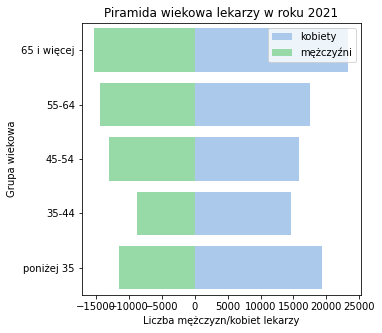

In [41]:
fig, axes = plt.subplots(1,1)
plt.rcParams["figure.figsize"] = (10,10)
bar_plot = sns.barplot(x='Kobiety', y='Wiek',data=df, order=ageclass[::-1], lw=0, color ="b", label="kobiety")
bar_plot = sns.barplot(x='Mężczyźni', y='Wiek', data=df, order=ageclass[::-1], lw=0, color="g", label="mężczyźni")
bar_plot.set(xlabel="Liczba mężczyzn/kobiet lekarzy", ylabel="Grupa wiekowa", title = f"Piramida wiekowa lekarzy w roku {year}")
bar_plot.legend()

## Piramida wiekowa lekarzy w 2021
Jesteśmy obecnie w sytuacji w której lekarze jako grupa starzeją się (szeroki wierzch piramidy). Drugą najliczniejszą grupę stanowią natomiast młodzi lekarze (poniżej 35 lat). Kobiet-lekarzy jest widocznie więcej niż mężczyzn.

W celu znalezienia przyczyny przejściowych spadków lekarzy, przedstawiono liczbę lekarzy w poszczególnych grupach wiekowych i to jaką część procentową ogólnej liczby lekarzy w danym roku stanowi dana grupa wiekowa


[25.098534843875203, 24.539804126853703, 24.539804126853703, 22.677814526455624, 22.150335903767367, 21.948489808480577, 21.42725793903388, 20.909058347362013, 20.44431802434559, 20.00763538118172, 19.54919131444911, 19.18739460370995]


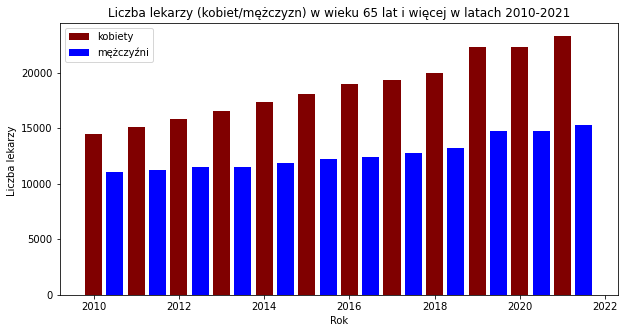

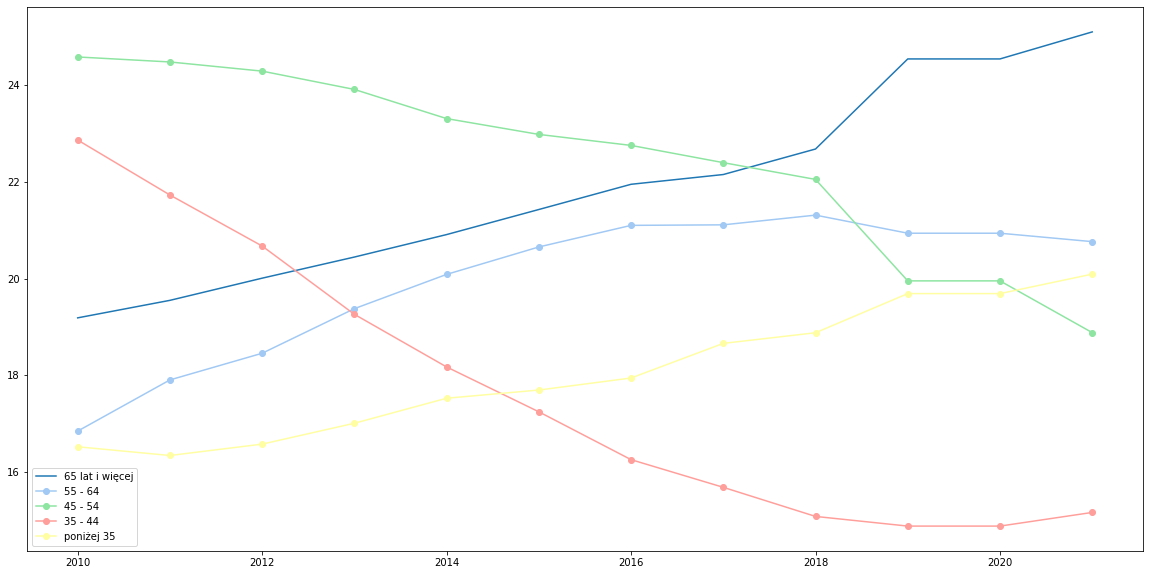

In [26]:

over65_m = [int(x.replace(" ", "")) for x in doc_age['65 i więcej M']]
over65_k = [int(x.replace(" ", "")) for x in doc_age['65 i więcej K']]
k_5564 = [int(x.replace(" ", "")) for x in doc_age['55-64 K']]
m_5564 = [int(x.replace(" ", "")) for x in doc_age['55-64 M']]
k_4554 = [int(x.replace(" ", "")) for x in doc_age['45-54 K']]
m_4554 = [int(x.replace(" ", "")) for x in doc_age['45-54 M']]
k_3544 = [int(x.replace(" ", "")) for x in doc_age['35-44 K']]
m_3544 = [int(x.replace(" ", "")) for x in doc_age['35-44 M']]
under35_k = [int(x.replace(" ", "")) for x in doc_age['poniżej 35 K']]
under35_m = [int(x.replace(" ", "")) for x in doc_age['poniżej 35 M']]
total_int = [int(x.replace(" ", "")) for x in doc_age['ogółem']]
over65_sum_k_m = [x+y for x,y in zip(over65_m,over65_k)]
over65_sum_proc = [(x/y)*100 for x,y in zip(over65_sum_k_m, total_int)]
sum_5564 = [x+y for x,y in zip(k_5564,m_5564)]
sum_proc_5564 = [(x/y)*100 for x,y in zip(sum_5564,total_int)]
sum_4554  = [x+y for x,y in zip(k_4554,m_4554)]
sum_proc_4554 = [(x/y)*100 for x,y in zip(sum_4554,total_int)]
sum_3544 = [x+y for x,y in zip(k_3544,m_3544)]
sum_proc_3544 = [(x/y)*100 for x,y in zip(sum_3544,total_int)]
under35_sum =  [x+y for x,y in zip(under35_k,under35_m)]
under35_sum_proc = [(x/y)*100 for x,y in zip(under35_sum,total_int)]
years = doc_age['rok']
print(over65_sum_proc)
barWidth = 0.5
years_b = [x + barWidth for x in years]
plt.rcParams["figure.figsize"] = (20,10)
def age_m_w_plot(m,w,xm,xw,tit):
        fig = plt.figure(figsize = (10, 5))
        # creating the bar plot
        plt.bar(xw, w, color ='maroon',
                width = 0.4,label="kobiety")
        plt.bar(xm, m, color ='blue',
                width = 0.4, label="mężczyźni")
        plt.xlabel("Rok")
        plt.ylabel("Liczba lekarzy ")
        plt.title(tit)
        plt.legend()
        plt.show()

age_m_w_plot(over65_m,over65_k,years_b,years,'Liczba lekarzy (kobiet/mężczyzn) w wieku 65 lat i więcej w latach 2010-2021')
plt.plot(years, over65_sum_proc, label = "65 lat i więcej")
plt.plot(years, sum_proc_5564, 'ob-',label = "55 - 64")
plt.plot(years, sum_proc_4554,'og-', label = "45 - 54")
plt.plot(years, sum_proc_3544, 'or-',label = "35 - 44")
plt.plot(years, under35_sum_proc, 'oy-',label = "poniżej 35")
plt.title("Procentowy udział poszczególnych grup wiekowych w ogólnej liczbie lekarzy w latach 2010-2021")
plt.legend()
plt.show()

## Procentowy udział grup wiekowych lekarzy w ogólnej liczbie lekarzy
Wykres ten potwierdza największy udział lekarzy powyżej 65 roku życia w ogólnej liczbie lekarzy. Od 2010 obserwowany jest również wzrost udziału młodych lekarzy z około 17 do 21%. Grupa wiekowa 45-54 jak i 35-44 wykazuje ogólną tendencję spadkową. 

Widać już, które grupy wiekowe mają największy udział we wzroście liczby lekarzy. Pozwala to zawęzić zakres poszukiwanych czynników skorelowanych.


## Limity miejsc na kierunek lekarski


In [48]:
limity = pd.read_csv(r'..\data\external\limity_miejsc_lekarski.csv', index_col = 0)
# limity = limity.transpose()
limity = limity.transpose()



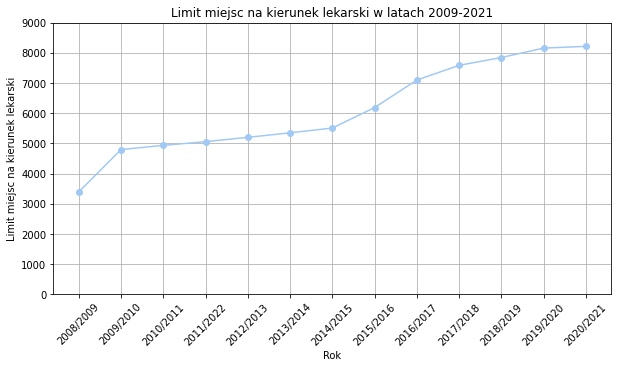

In [28]:
limity_ogolem = [8215,8158,7846,7587,7100,6188,5510,5352,5202,5059,4937,4797,3392]
lata = ['2020/2021','2019/2020','2018/2019','2017/2018','2016/2017','2015/2016','2014/2015','2013/2014',
'2012/2013','2011/2022','2010/2011','2009/2010','2008/2009']
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

plt.plot(lata[::-1],limity_ogolem[::-1],'ob-')
plt.title("Limit miejsc na kierunek lekarski w latach 2009-2021")
plt.xlabel("Rok")
plt.xticks(rotation=45)
plt.grid()
plt.ylim(ymin=0, ymax=9000)
plt.ylabel("Limit miejsc na kierunek lekarski")

plt.show()

## Limity miejsc na kierunek lekarski

Limity miejsc na kierunek lekarski ogłaszane co roku przez ministra zdrowia w rozporządzeniu zwiększyły się od 2008 roku o około 150%.
Warto wobec tego zastanowić się jakie wydarzenia polityczne miały związek ze zwiększeniem limitów, jako że zwiększone limity będą prawdpodobnie pozytywnie skorelowane z liczbą młodych lekarzy w Polsce.

Ponadto chcielibyśmy sprawdzić powiązanie współczynnika emigracji z liczbą lekarzy.

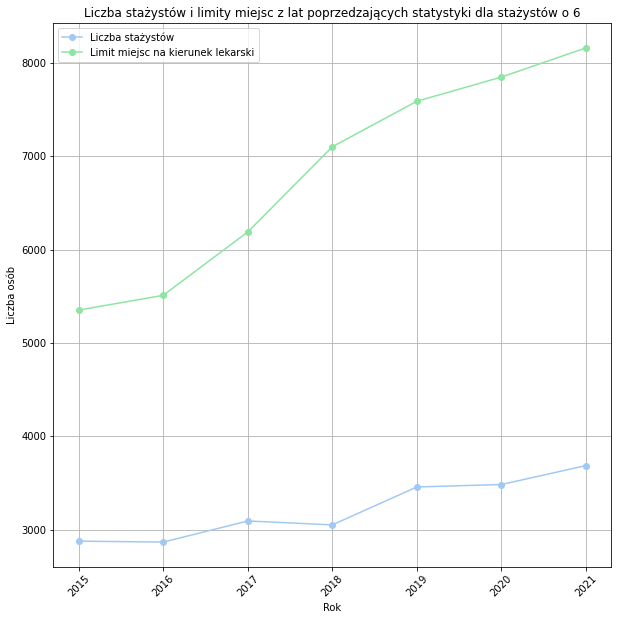

In [29]:
#zmapować liczbę poniżej 35 roku na limity miejsc, 
#zmapować liczbę absolwentów/stażystów na limity miejsc ogłoszone 6 lat wcześniej
#popatrzeć na statystyki emigracji
#https://izp.wnz.cm.uj.edu.pl/pl/blog/publikacja-czy-polscy-lekarze-rozwazaja-emigracje-zawodowa/
plt.rcParams["figure.figsize"] = (10,10)
stazysci = ([int(x.replace(" ", "")) for x in doc_age['stażyści']][5:])[::-1]
limity_ogolem_cut = (limity_ogolem[1:-5])[::-1]
lata_cut = [2015,2016,2017,2018,2019,2020,2021]
plt.plot(lata_cut,stazysci,'ob-', label = "Liczba stażystów")
plt.plot(lata_cut,limity_ogolem_cut,'og-',label = "Limit miejsc na kierunek lekarski")
plt.title("Liczba stażystów i limity miejsc z lat poprzedzających statystyki dla stażystów o 6")
plt.xlabel("Rok")
plt.xticks(rotation=45)
plt.grid()
# plt.ylim()
plt.ylabel("Liczba osób")
plt.legend()
plt.show()

##
Liczba studentów kierunków lekarskich, na tle studentów w Polsce

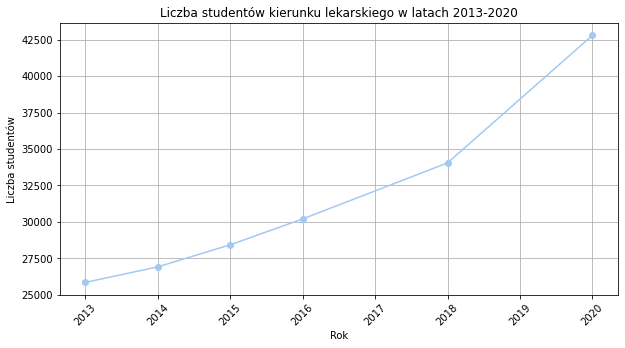

In [31]:
plt.rcParams["figure.figsize"] = (10,5)
studenci_lek = [25846,26912,28424,30200,34044,42794]
lata = [2013,2014,2015,2016,2018,2020]
plt.plot( lata,studenci_lek,'ob-')
plt.title("Liczba studentów kierunku lekarskiego w latach 2013-2020")
plt.xlabel("Rok")
plt.xticks(rotation=45)
plt.grid()
# plt.ylim(ymin=0)
plt.ylabel("Liczba studentów")

plt.show()

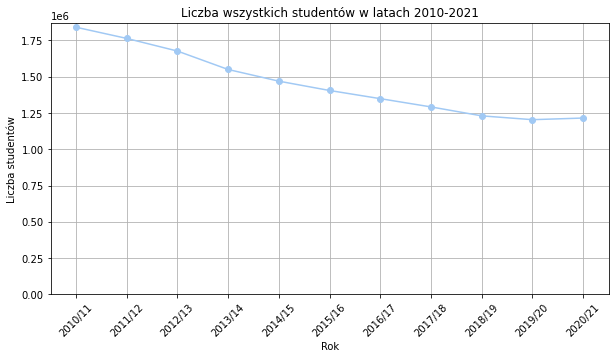

In [37]:
## z czego wynika zwiększenie limitu miejsc? czy to odpowiedź na zainteresowanie, strajki, zmiany władzy
## liczba studentów w polsce ogólnie
#liczba młodych w tym przedziale wiekowym
#zarobki lekarzy, na tle średnich zarobków
plt.rcParams["figure.figsize"] = (10,5)
studenci_ogol = pd.read_csv(r'..\data\external\wykres_szkolnictwo_wyzsze_w_roku_akademickim_2020-2021.csv', sep=';')
y = studenci_ogol.iloc[0].values[1:]
x = studenci_ogol.columns[1:]
plt.plot( x,y,'ob-')
plt.title("Liczba wszystkich studentów w latach 2010-2021")
plt.xlabel("Rok")
plt.xticks(rotation=45)
plt.grid()
plt.ylim(ymin=0)
plt.ylabel("Liczba studentów")

plt.show()

## Piramida wiekowa ludności w Polsce w roku 2021

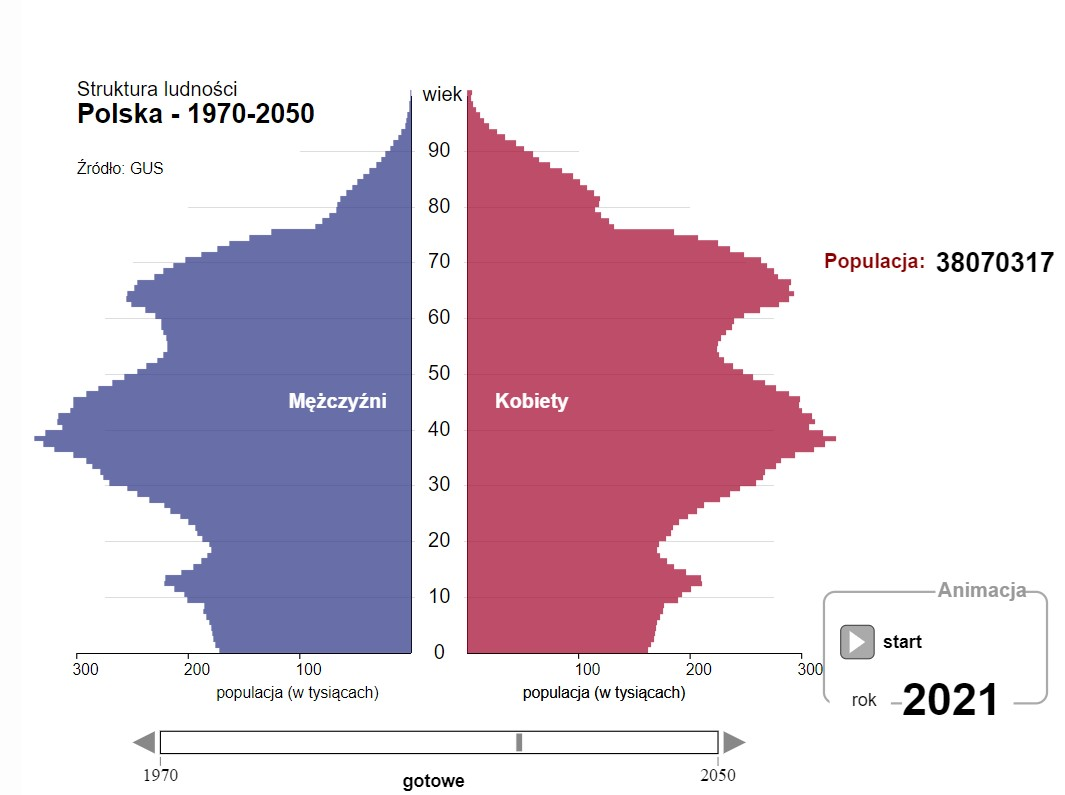

In [ ]:
from IPython.display import Image
Image(filename='..\data\external\piramida_wieku_polska_2020.jpg') 

## Migracje lekarzy
Jako przyczynę niewystarczającej ilości lekarzy podaje się często ich emigrację. Jest to jednak trudny do zbadania obszar ze względu na brak oficjalnych danych o emigracjach lekarzy - emigrację szacuje się w oparciu o liczbę zaświadczeń o kwalifikacjach zawodowych wydanych przez Naczelną Izbę Lekarską, z racji tego, że są one niezbędne przy ubieganiu się o stanowisko medyczne w innych krajach Unii Europejskiej

<AxesSubplot:title={'center':'Liczba zaświadczeń wydanych przez NIL 2017-2020'}, xlabel='years'>

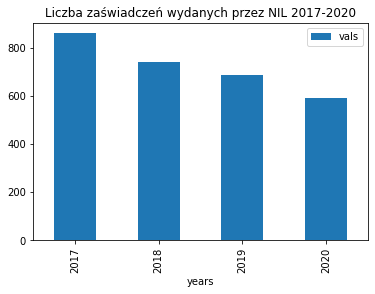

In [12]:
dict_zaswiadczenia = {'years':[2017, 2018, 2019, 2020], 'vals': [860,741, 686, 593]}
zaswiadczenia = pd.DataFrame(dict_zaswiadczenia)
zaswiadczenia.head()
zaswiadczenia.plot(x='years', y='vals', kind="bar", title="Liczba zaświadczeń wydanych przez NIL 2017-2020")
